In [1]:
import pandas as pd
import numpy as np
import spotipy 
sp = spotipy.Spotify() 
from spotipy.oauth2 import SpotifyClientCredentials 
cid ='96c23a48f808449f88bd8d8f44962e40' 
secret ='596d6b18cd104b79b9566e9776274c6d'

In [2]:
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret) 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) 
sp.trace=False

In [3]:
def playlist_ids(X):
    playlist_uris = []
    for i,ids in enumerate(X["playlists"]['items']):
        playlist_uris.append(ids["uri"])
    return playlist_uris

In [4]:
def songs_database(playlist_uris):
    songs_df = pd.DataFrame()
    for uri in playlist_uris:
        playlist = sp.user_playlist("spotify",uri) 
        songs = playlist["tracks"]["items"] 
        ids = []
        song_names = []
        song_artist = []
        
        for i in range(len(songs)): 
            ids.append(songs[i]["track"]["id"])
            song_names.append(songs[i]["track"]["name"])
            song_artist.append(songs[i]["track"]["artists"][0]['name'])
        features = sp.audio_features(ids)
        df1 = pd.DataFrame()
        for each in features:
            if(each != None):
                d = pd.DataFrame(each,index=[0])
            df1 = df1.append(d,ignore_index=True)
        df2 = pd.DataFrame()
        df2["track_title"] = song_names
        df2["track_artist"] = song_artist
        df2["playlist_name"] = playlist["name"]
        df3 = pd.concat([df2,df1], axis=1)
        
        if songs_df.empty:
            songs_df = df3
        else:
            songs_df = pd.concat([songs_df,df3],axis=0,ignore_index=True)
    
    return songs_df

In [5]:
train_cols = ['danceability','energy', 'key', 'loudness', 'speechiness', 'acousticness',
              'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
target_cols = "genre_class"

In [6]:
# Getting all playlists under "Focus" and "Party" genres
focus = (sp.category_playlists(category_id="focus", country="US", limit=50, offset=0))
classical = (sp.category_playlists(category_id="classical", country="US", limit=50, offset=0))
party = (sp.category_playlists(category_id="party", country="US", limit=50, offset=0))

In [7]:
cats = (sp.categories(country="US", limit=50, offset=0))
categories = []

for each in cats["categories"]["items"]:
    categories.append(each["id"])

In [8]:
focus_uris = playlist_ids(focus)
classical_uris = playlist_ids(classical)
party_uris = playlist_ids(party)

In [9]:
focus_songs = songs_database(focus_uris)
classical_songs = songs_database(classical_uris)

In [10]:
party_songs = songs_database(party_uris)

In [11]:
party_songs[target_cols] = 0
#party_songs
focus_songs[target_cols] = 1
#focus_songs
classical_songs[target_cols] = 2
#classical_songs

In [12]:
complete_songs = pd.concat([party_songs,focus_songs,classical_songs],axis=0)
#complete_songs

In [13]:
complete_songs["genre_class"].value_counts()

1    4034
2    3434
0    3063
Name: genre_class, dtype: int64

In [30]:
pd.DataFrame(columns=train_cols)

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms


In [14]:
genre_labels = {0:"Party",1:"Focus",2:"Classical"}

In [15]:
inv_map = {v: k for k, v in genre_labels.items()}
inv_map

{'Party': 0, 'Focus': 1, 'Classical': 2}

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from sklearn import metrics

## Modified K-Means ##
def cluster_centroids(X):
    return((X.mean()))

playlist_clusters = {}
features = complete_songs.sample(frac=1).reset_index(drop=True)
result_cols = ["track_title","track_artist"]
target = features[target_cols]

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=1)
y_test = y_test.reset_index(drop=True)

for each in range(3):
    temp = pd.DataFrame()
    temp = X_train[X_train["genre_class"] == each]
    temp2 = pd.DataFrame(scaler.fit_transform(temp[train_cols]))
    k = genre_labels[each]
    playlist_clusters[k] = cluster_centroids(temp2)

playlist_clusters = pd.DataFrame.from_dict(playlist_clusters, orient='index')
playlist_clusters

,0,1,2,3,4,5,6,7,8,9,10
Party,0.646607,0.698916,0.489824,0.651290,0.128365,0.138261,0.090303,0.174637,0.614076,0.419035,0.264680
Focus,0.479003,0.246403,0.457876,0.704470,0.081383,0.753705,0.793122,0.139306,0.259909,0.503446,0.116620
Classical,0.318279,0.136860,0.456160,0.578589,0.083348,0.893781,0.720586,0.115017,0.164093,0.475224,0.067419


In [17]:
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test[train_cols]))
X_test_scaled

,0,1,2,3,4,5,6,7,8,9,10
0,0.855359,0.742995,0.909091,0.883892,0.348259,0.016049,0.000000,0.110413,0.648980,0.351740,0.065793
1,0.227888,0.198984,0.636364,0.624957,0.058085,0.772085,0.709000,0.115646,0.052041,0.336385,0.068207
2,0.476587,0.040281,0.909091,0.404877,0.069776,0.997992,0.890000,0.093668,0.052347,0.313804,0.063737
3,0.798127,0.642993,0.454545,0.875290,0.125622,0.216855,0.000104,0.061852,0.546939,0.707944,0.050120
4,0.682622,0.465989,0.636364,0.823958,0.094527,0.264045,0.000031,0.041026,0.948980,0.849661,0.068230
...,...,...,...,...,...,...,...,...,...,...,...
2628,0.466181,0.027780,0.636364,0.404326,0.088060,0.998996,0.928000,0.083203,0.360204,0.577458,0.029891
2629,0.294485,0.033081,0.818182,0.452144,0.046891,0.403605,0.024300,0.058922,0.270408,0.544137,0.037359
2630,0.208117,0.016080,0.181818,0.386190,0.046269,0.968875,0.889000,0.226583,0.109184,0.352464,0.035870
2631,0.515088,0.334987,0.909091,0.616582,0.061443,0.829315,0.873000,0.086342,0.039184,0.482896,0.039273


In [18]:
def distances(X):
    X = np.array(X)
    df = pd.DataFrame(index=playlist_clusters.index.copy())
    for index,each in playlist_clusters.iterrows():
        Y = np.array(each)
        distance = np.linalg.norm(X - Y)
        df.loc[index,"distance"] = distance 
    return (df.idxmin(axis = 0)[0])

predictions = []

for index,song in X_test_scaled.iterrows():
    predictions.append(distances(song))
    
predictions = pd.Series(predictions)
predictions = predictions.rename("Assigned_Genre")

print(predictions)

0           Party
1       Classical
2       Classical
3           Party
4           Party
          ...    
2628    Classical
2629    Classical
2630    Classical
2631        Focus
2632        Party
Name: Assigned_Genre, Length: 2633, dtype: object


In [19]:
y_pred = predictions.map(inv_map)
#y_pred

In [20]:
count=0
for i in range(len(y_pred)):
    if(y_pred[i] == y_test[i]):
        count+=1
acc = count/len(y_pred)
print("Accuracy: ",acc*100)

Accuracy:  70.18609950626661


In [21]:
X_final = X_test[result_cols]
X_final = X_final.reset_index(drop=True)
songs_result = pd.concat([X_final,predictions],axis=1,)
songs_result

,track_title,track_artist,Assigned_Genre
0,Savage Remix (feat. Beyoncé),Megan Thee Stallion,Party
1,"Marian and Robin (From ""The Adventures of Robi...",Erich Wolfgang Korngold,Classical
2,Population,Eric Sebastian,Classical
3,Dream Girl - Remix,Ir Sais,Party
4,Que Bello,Sonora Tropicana,Party
...,...,...,...
2628,We Will Make It,Finn Forsberg,Classical
2629,6 Miniatures (Arr. T. Batiashvili for Violin &...,Sulkhan Tsintsadze,Classical
2630,"Il sogno di Scipione, K. 126: Overture. Andante",Wolfgang Amadeus Mozart,Classical
2631,Making Water,Harry Gregson-Williams,Focus


In [22]:
playlist_clusters.columns = train_cols
polarplot = playlist_clusters.to_dict("index")

for i, key in enumerate(polarplot.keys()):
    if (i>0 and i<3):
        values=list(playlist_clusters.iloc[i])
        print(values)

[0.4790032795296336, 0.24640291627062724, 0.45787578757875874, 0.7044702222988549, 0.08138275600413215, 0.7537047101574758, 0.7931216712079208, 0.13930583401019248, 0.25990870390409754, 0.5034462919849234, 0.11661970886718946]
[0.3182793277915243, 0.1368595478716648, 0.4561600561600566, 0.5785888232858599, 0.08334828216860905, 0.8937810892305617, 0.7205862718877759, 0.11501736342903815, 0.1640931005884759, 0.47522401998111513, 0.06741949428937132]


[0.6466068351055188, 0.6989161659165841, 0.4898236092265948, 0.6512897706092176, 0.12836529558037826, 0.138260526071297, 0.09030316010126958, 0.1746374416034825, 0.6140760560395107, 0.41903468572963337, 0.2646802233268433]
[0.4790032795296336, 0.24640291627062724, 0.45787578757875874, 0.7044702222988549, 0.08138275600413215, 0.7537047101574758, 0.7931216712079208, 0.13930583401019248, 0.25990870390409754, 0.5034462919849234, 0.11661970886718946]


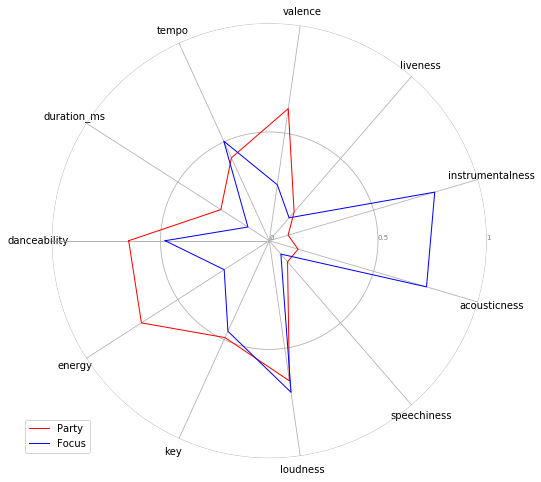

In [23]:
from math import pi
import matplotlib.pyplot as plt
%matplotlib inline

N = len(train_cols)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)
ax.set_theta_offset(pi)
ax.set_theta_direction(1)

ax.spines["polar"].set_visible(False)

plt.xticks(angles, train_cols)

ax.set_rlabel_position(-180)
plt.yticks([0, 0.5, 1], ["0", "0.5","1"], color="grey", size=7)
plt.ylim(0, 1)

# Ind1
colors=['r', 'b', 'y']
for i, key in enumerate(polarplot.keys()):
    if i <2:
        values=list(playlist_clusters.iloc[i])
        print(values)
        values += values[:1]
        ax.plot(angles, values, color=colors[i], linewidth=1, linestyle='solid', label=key)
 
# Add legend
plt.legend(bbox_to_anchor=(0.1, 0.1))
plt.show()
fig.savefig("Party vs Focus.png",dpi=300)